In [1]:
from matplotlib import pyplot as plt
from slab import datamanagement
from slab import dsfit
from slab import dataanalysis
from slab.datamanagement import SlabFile
from numpy import *
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tabulate import tabulate

data_dir = r'S:\_Data\160216 -M007 Trident Hybrid Coupler setup\data'
exp_dir = r'S:\_Data\160216 -M007 Trident Hybrid Coupler setup\experiment'
nbfig_dir = r'C:\Users\slab\Google Drive\grad school\schuster lab\Analysis\IPython Notebooks\Figures'

sys.path.append(exp_dir)
sys.path.append(r'C:\Users\slab\Google Drive\grad school\schuster lab')
from data_cache import dataCacheProxy
from Analysis.Modules import common, fit, anal, static_surface, trap_analysis

Idea: How to condense the data: 
 * Start with an x-y slice at certain z.
 * Fit the parabola, Do this along the channel (y-direction). This gives you a line plot. 
 * Take a next slice of z and repeat step (2) to get a 2D color plot for the electron frequency.

Potential problem: might not be parabolic in all regions, such that fits may fail, especially true for depths smaller than some fraction of the channel height.

In [44]:
reload(trap_analysis)

<module 'Analysis.Modules.trap_analysis' from 'C:\Users\slab\Google Drive\grad school\schuster lab\Analysis\Modules\trap_analysis.pyc'>

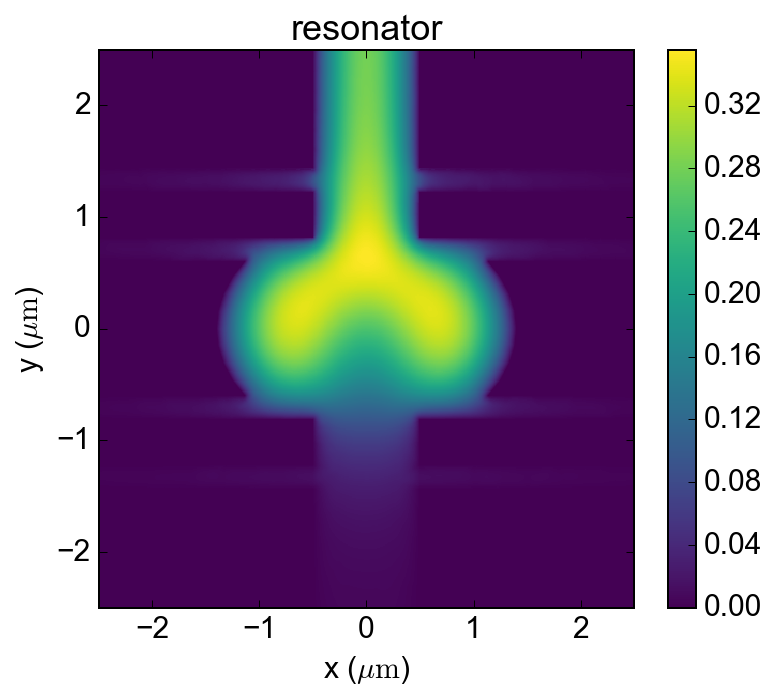

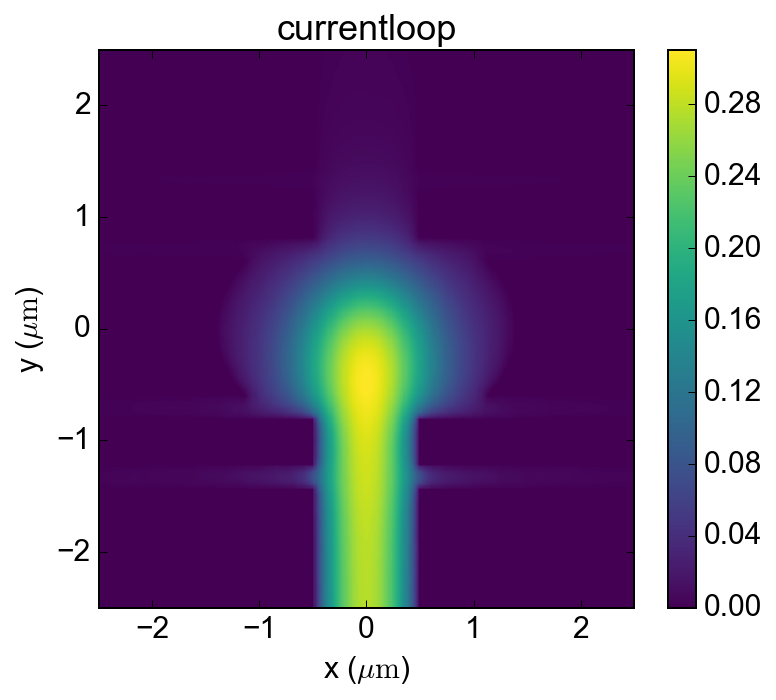

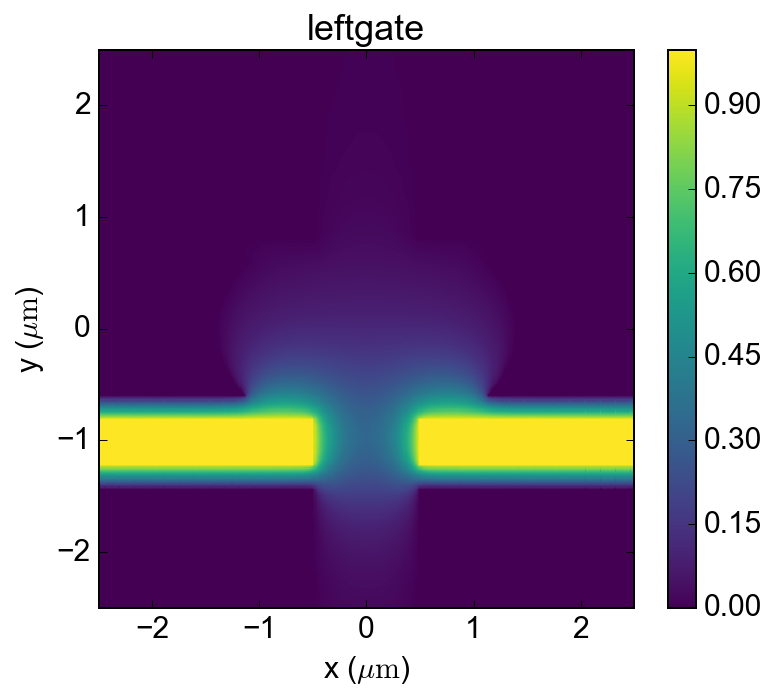

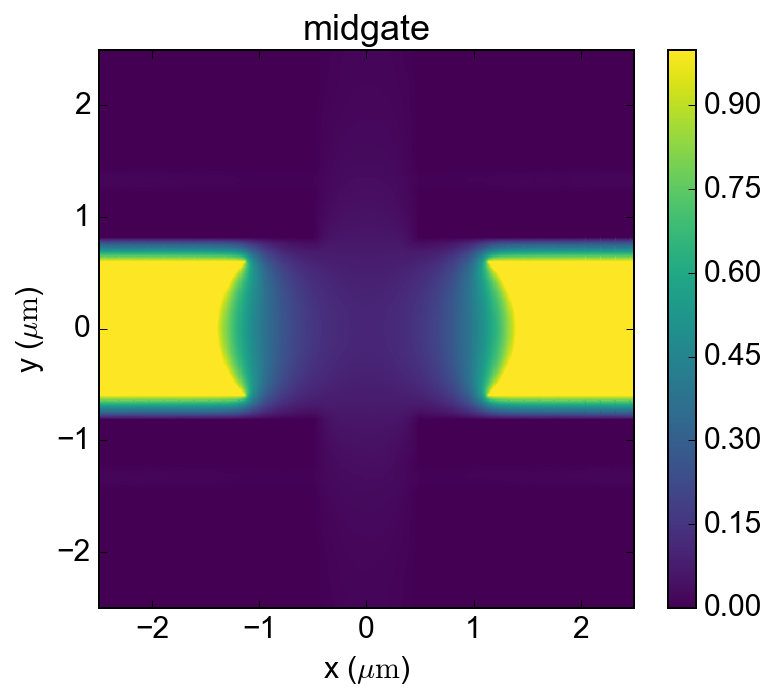

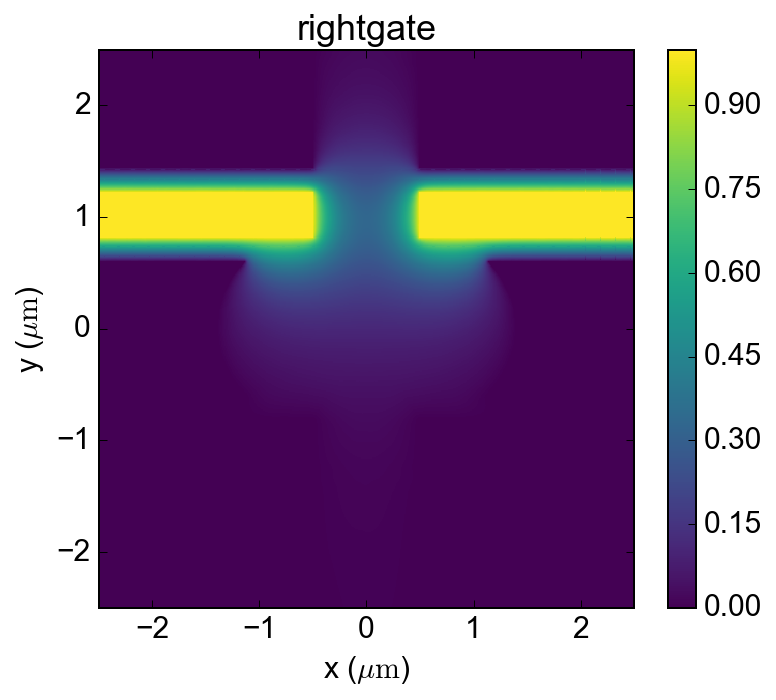

In [7]:
base_path = r'S:\Gerwin\Electron on helium\Maxwell\M016 Sweet Spot Exploration\0.1 pct accuracy'

fn_resonator = os.path.join(base_path, r'resonator_1V.fld')
fn_currentloop = os.path.join(base_path, r'currentloop_1V.fld')
fn_midgate = os.path.join(base_path, r'guard_center_1V.fld')
fn_rightgate = os.path.join(base_path, r'guard_right_1V.fld')
fn_leftgate = os.path.join(base_path, r'guard_left_1V.fld')

dicts = trap_analysis.load_potentials(fn_resonator, fn_currentloop, fn_leftgate, fn_midgate, fn_rightgate)
resonator, currentloop, leftgate, midgate, rightgate = dicts

f = 46.205 +/- 0.045 GHz


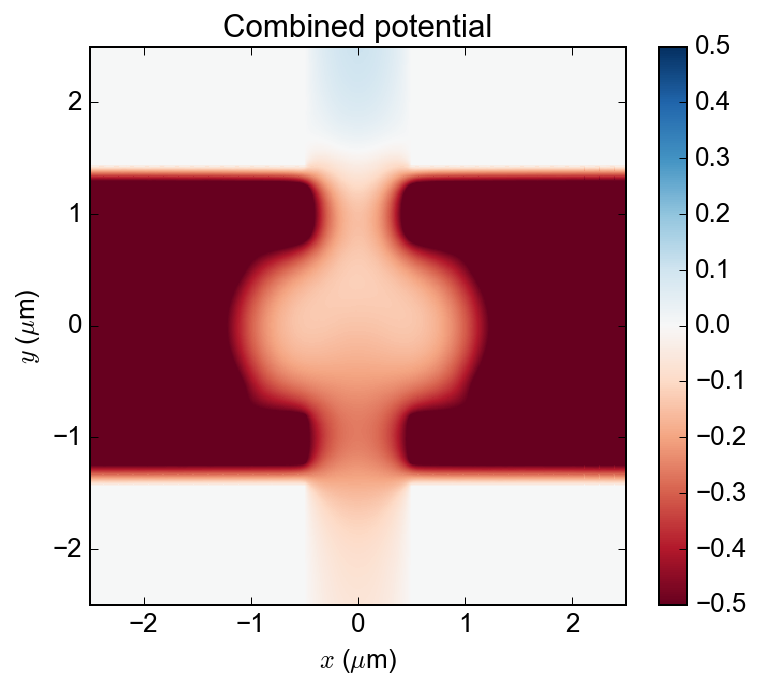

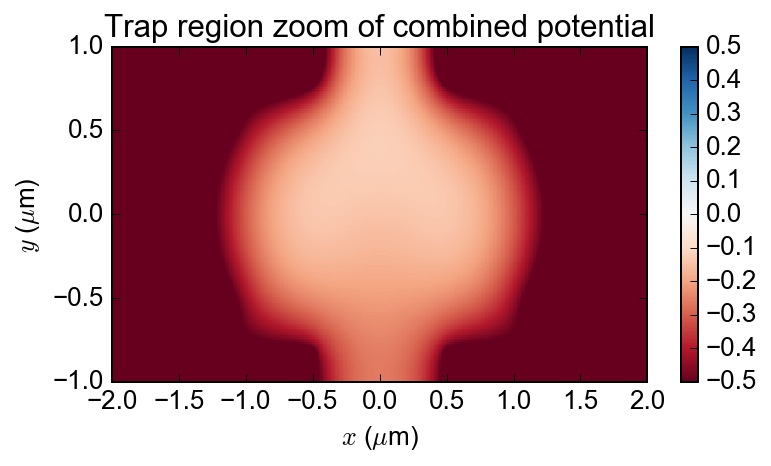

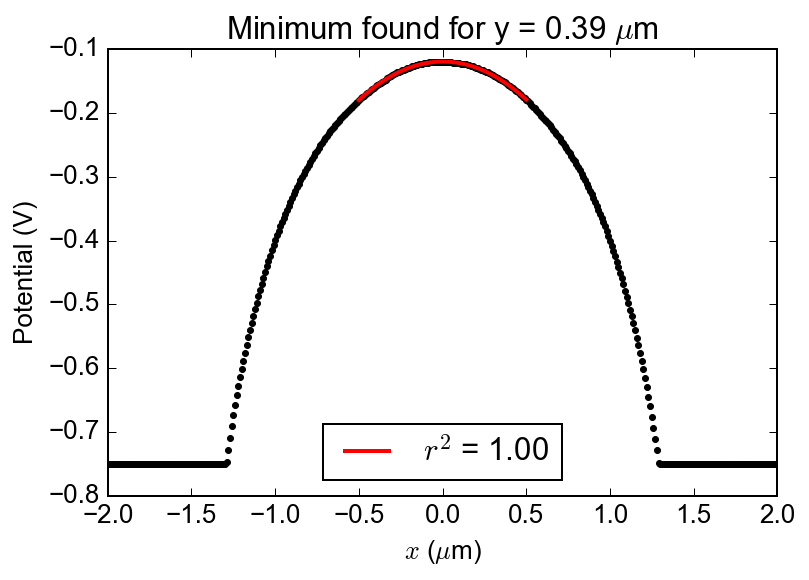

In [11]:
potentials = [resonator['V'], currentloop['V'], rightgate['V'], leftgate['V'], midgate['V']]
coefficients = [+0.50, -0.15, -0.80, -0.60, -0.75]

combined_potential = trap_analysis.get_combined_potential(array(potentials), array(coefficients))

plt.figure(figsize=(6.,5.))
common.configure_axes(13)
plt.title('Combined potential')
plt.pcolormesh(resonator['x']*1E6, resonator['y']*1E6, combined_potential, cmap=plt.cm.RdBu, vmin=-0.5, vmax=0.5)
plt.xlim(np.min(resonator['x']*1E6), np.max(resonator['x']*1E6))
plt.ylim(np.min(resonator['y']*1E6), np.max(resonator['y']*1E6))
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')

# Only look at the center of the trap region: 
x, y, V = static_surface.select_domain(resonator['x'], resonator['y'], combined_potential, 
                                       xdomain=(-2E-6, 2E-6), ydomain=(-1E-6, 1E-6))

plt.figure(figsize=(6.,3.))
common.configure_axes(13)
plt.title('Trap region zoom of combined potential')
plt.pcolormesh(x*1E6, y*1E6, V, cmap=plt.cm.RdBu, vmin=-0.5, vmax=0.5)
plt.xlim(np.min(x*1E6), np.max(x*1E6))
plt.ylim(np.min(y*1E6), np.max(y*1E6))
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')

# Create a slice along x, where the combined potential is minimized
plt.figure(figsize=(6.,4.))
common.configure_axes(13)
yminidx = argmax(V)/shape(V)[1]
fr, ferr = trap_analysis.fit_electron_potential(np.array(x[:]*1E6, dtype=float64), np.array(V[yminidx, :], dtype=float64), 
                                  fitdomain=(-0.5, 0.5), do_plot=True, 
                                  plot_title='Minimum found for y = %.2f $\mu$m'%(y[yminidx]*1E6))

f, sigma_f = trap_analysis.get_electron_frequency(fr, ferr, verbose=True)

In [16]:
potentials = [resonator, currentloop, rightgate, leftgate, midgate]
x, y, cropped_potentials = trap_analysis.crop_potentials(potentials, xdomain=(-2E-6, 2E-6), ydomain=(-1E-6, 1E-6))

=====  =============  =============
  V     f_min (GHz)    f_ctr (GHz)
=====  =============  =============
0.500       nan            nan
0.550       nan            nan
0.600       nan            nan
0.650       nan            nan
0.700       nan            nan
0.750       nan            nan
0.800       nan            nan
0.850      7.182          7.182
0.900     16.038         16.038
0.950     21.514         21.514
1.000     25.855         25.855
=====  =============  =============


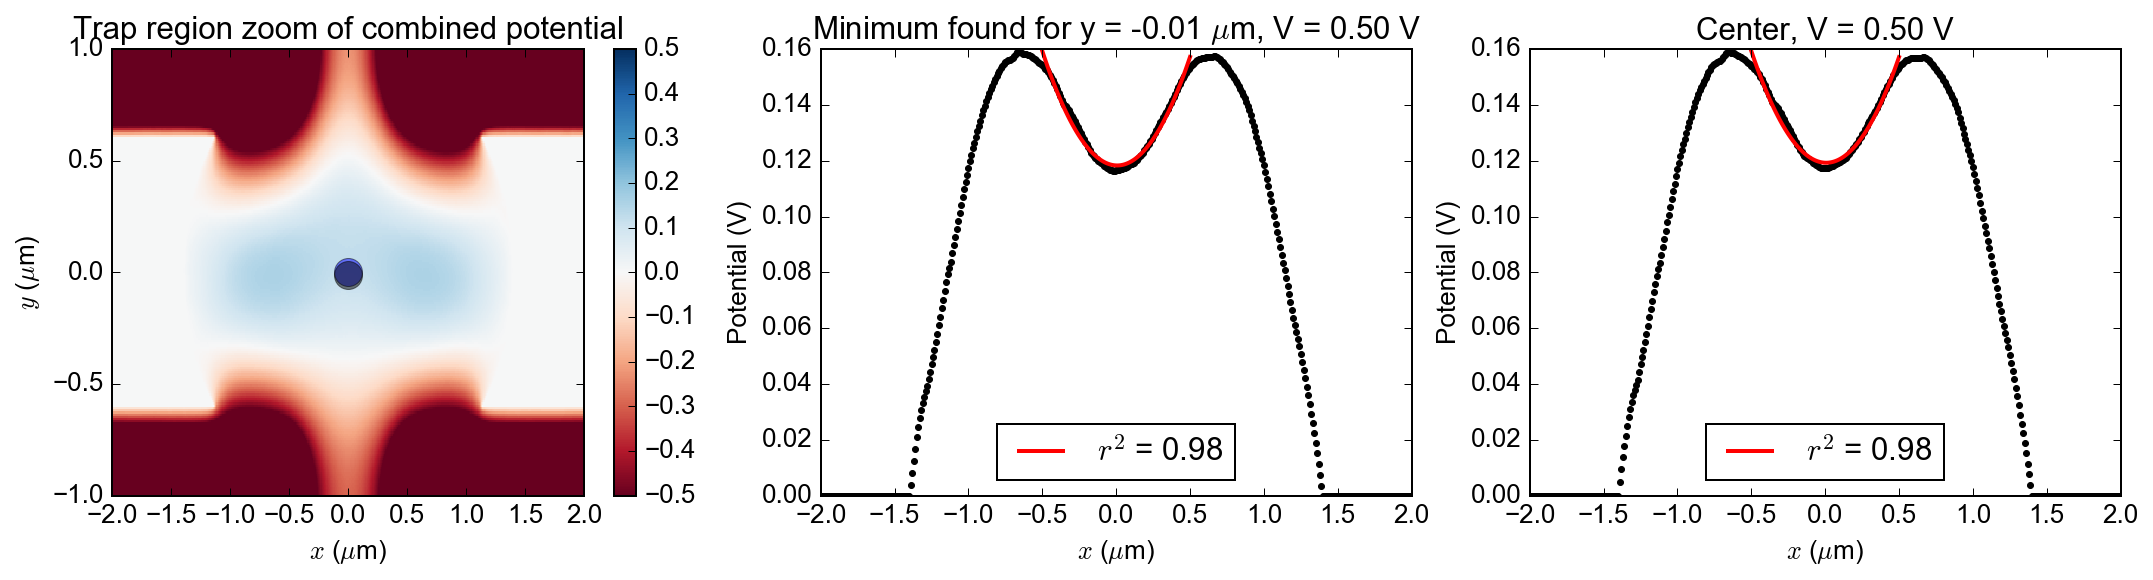

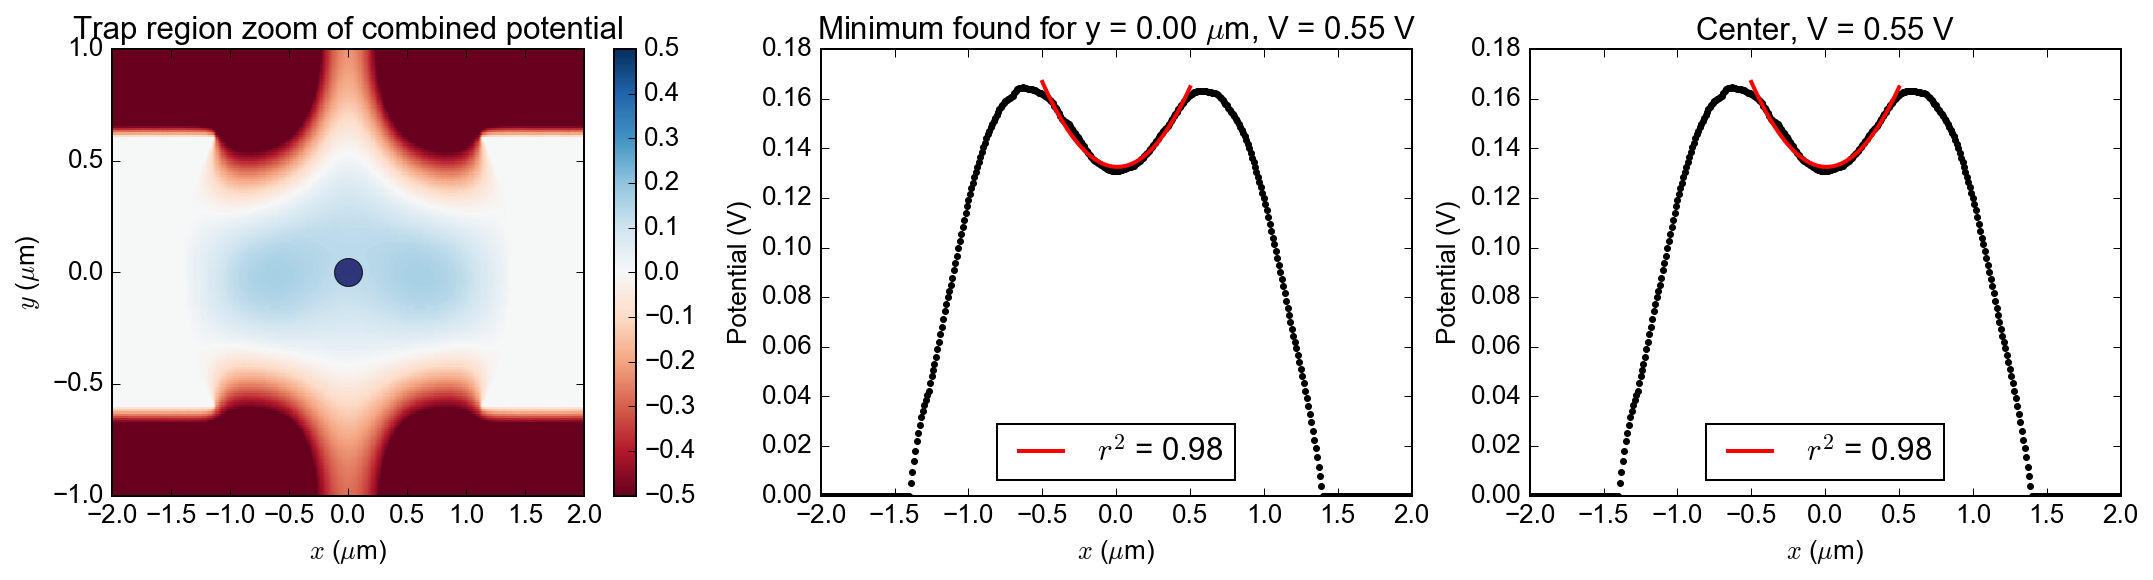

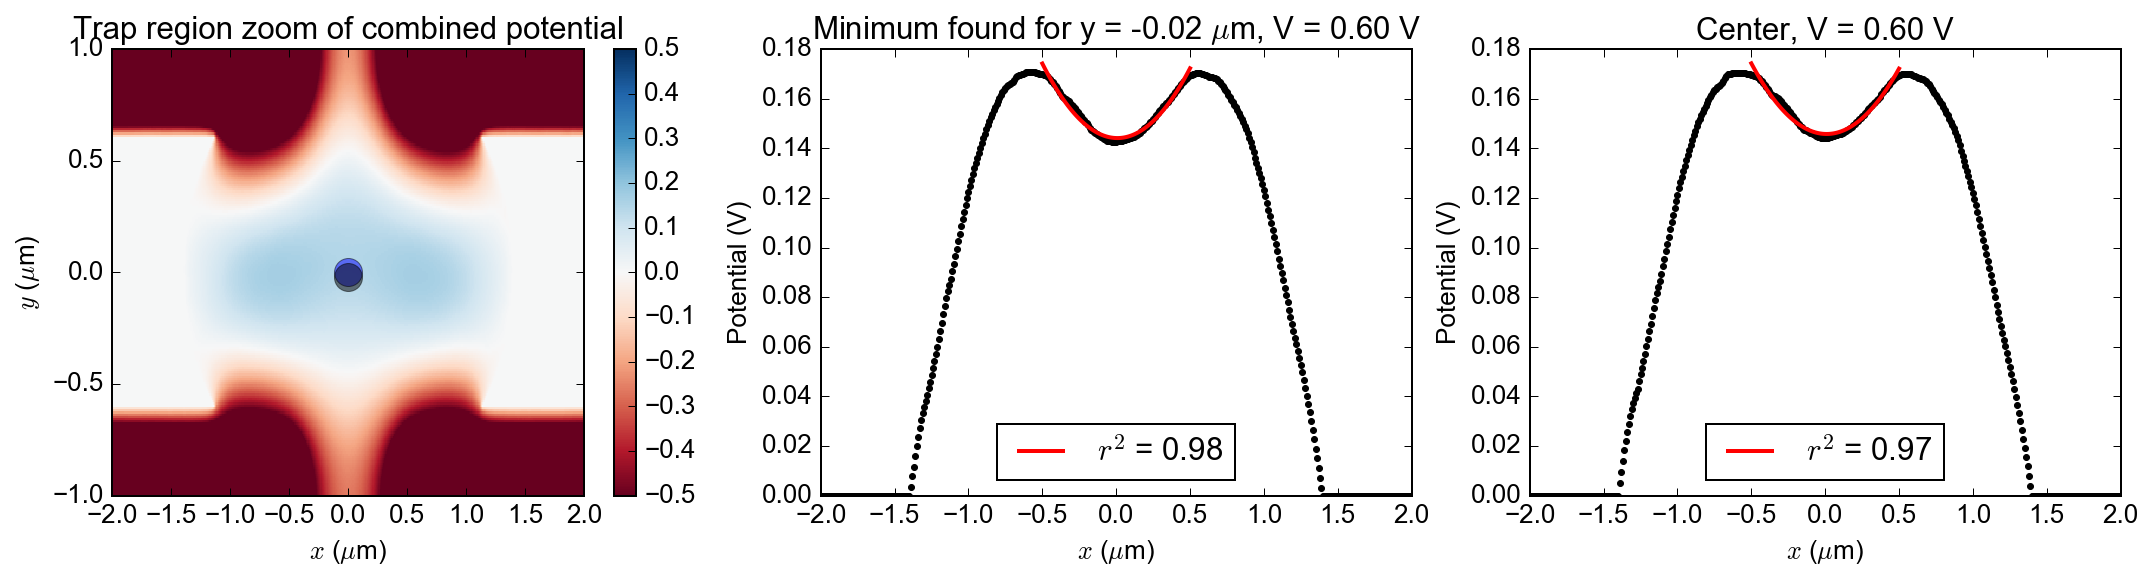

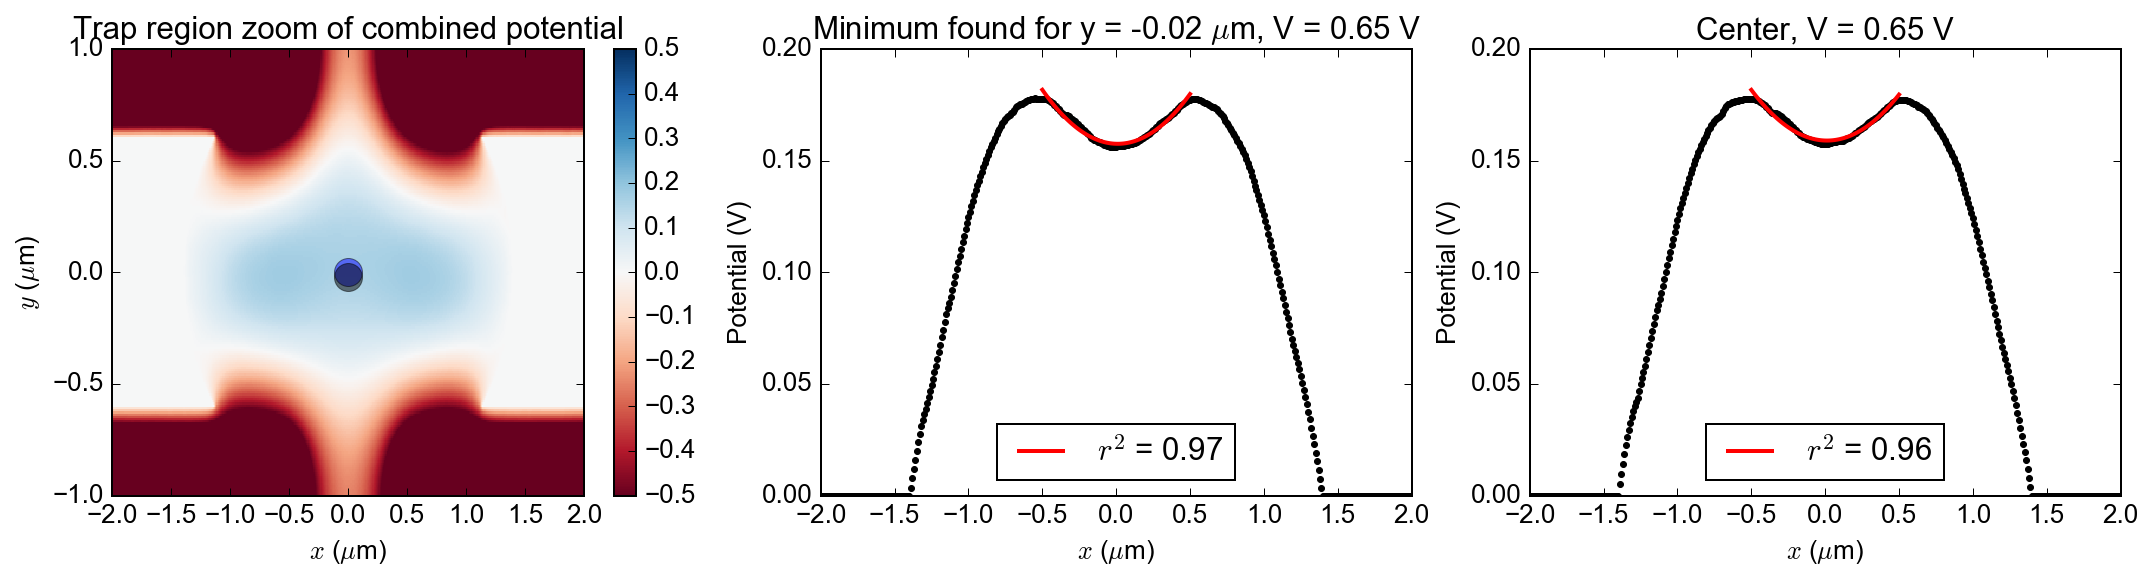

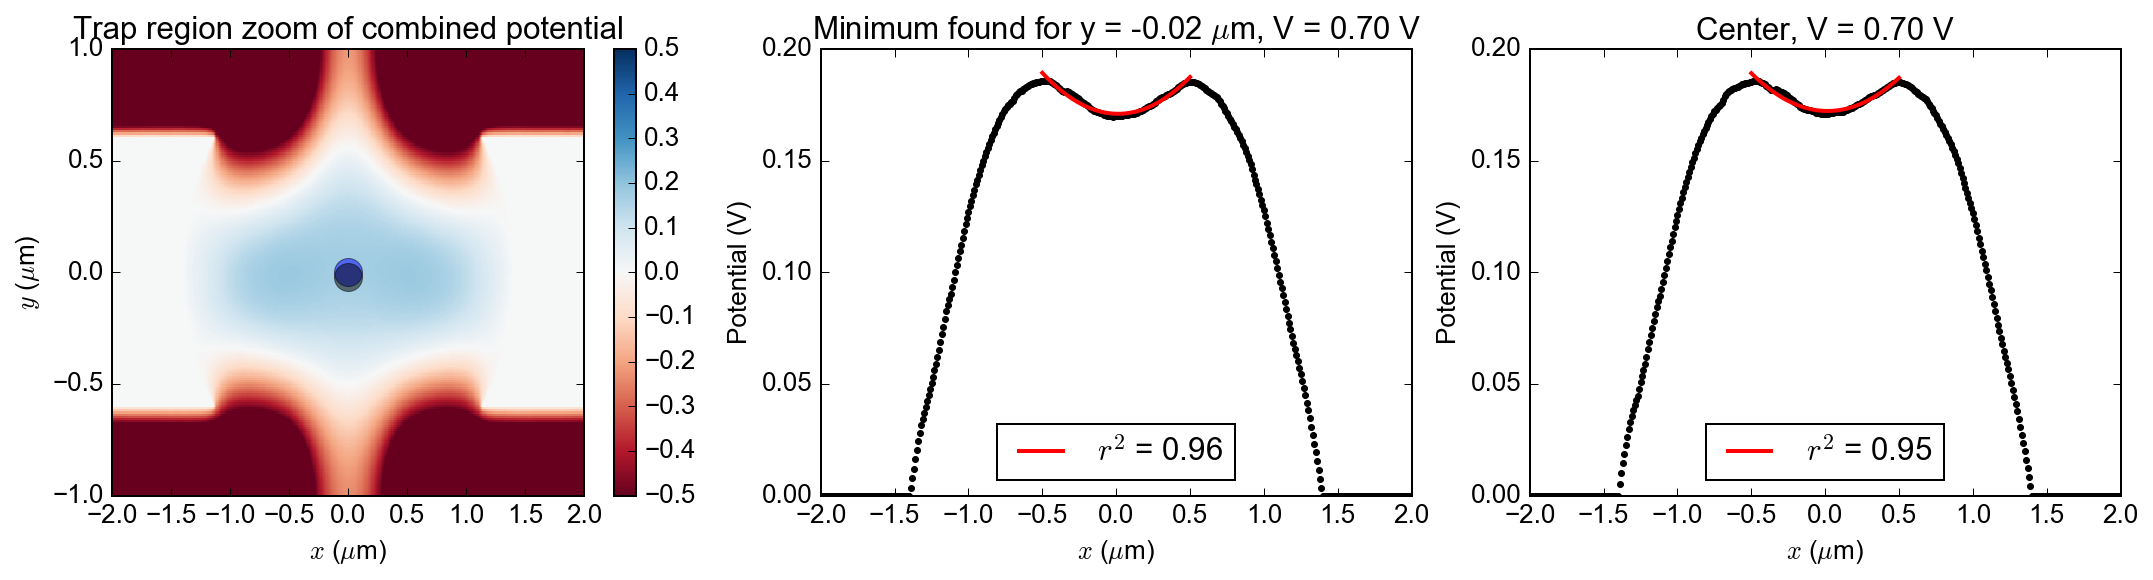

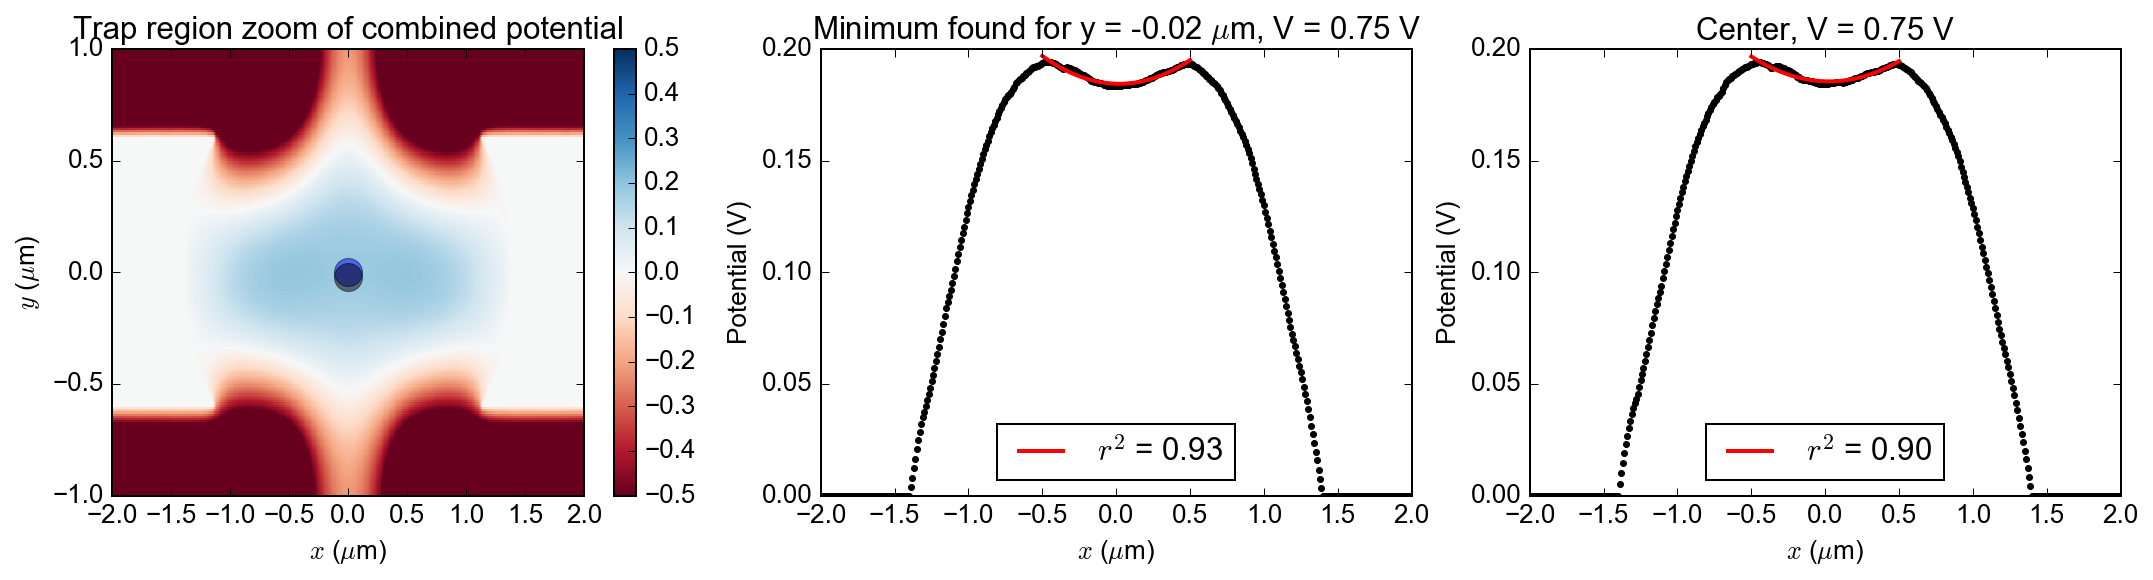

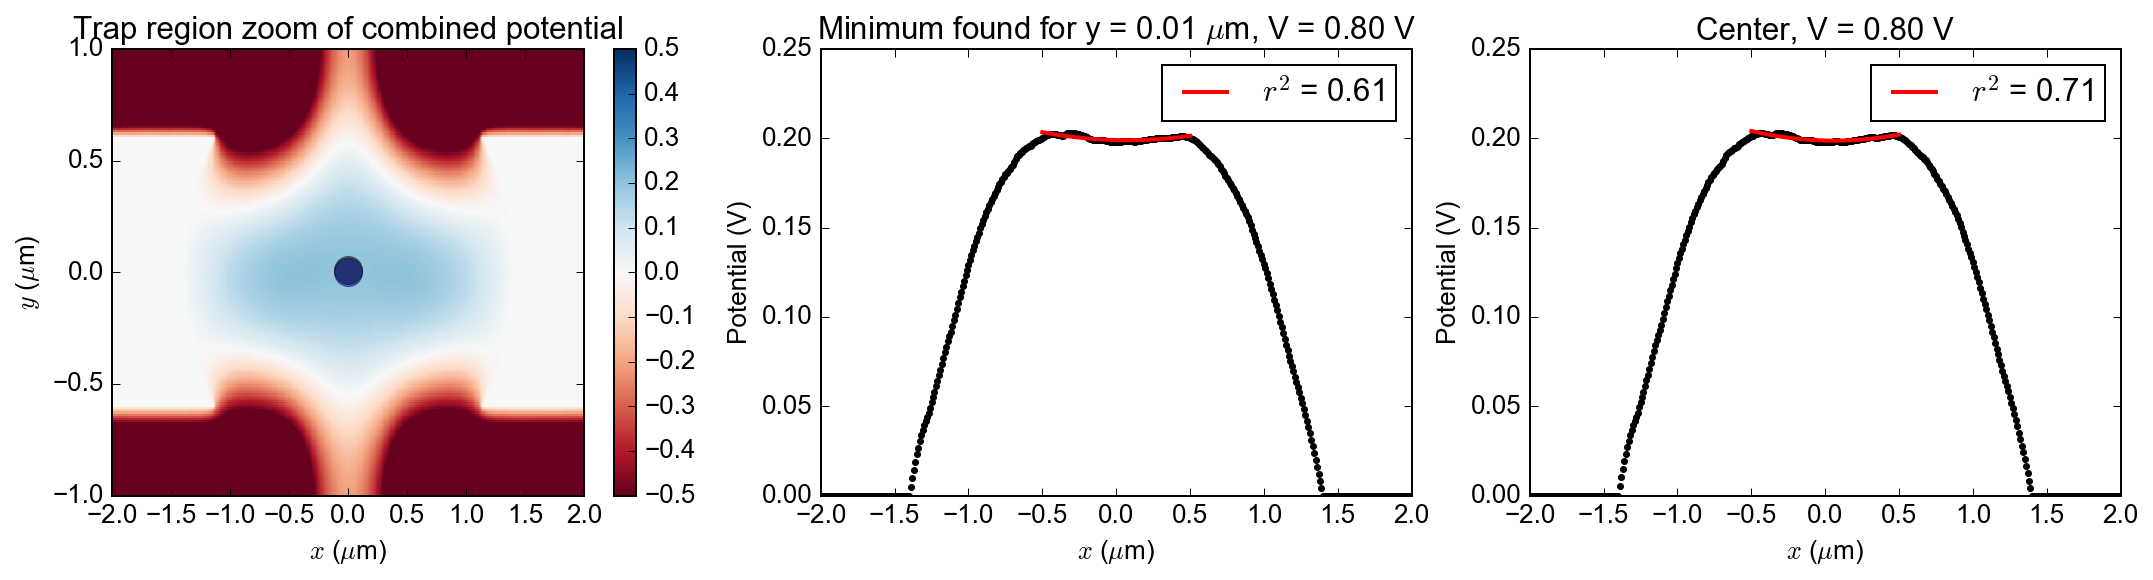

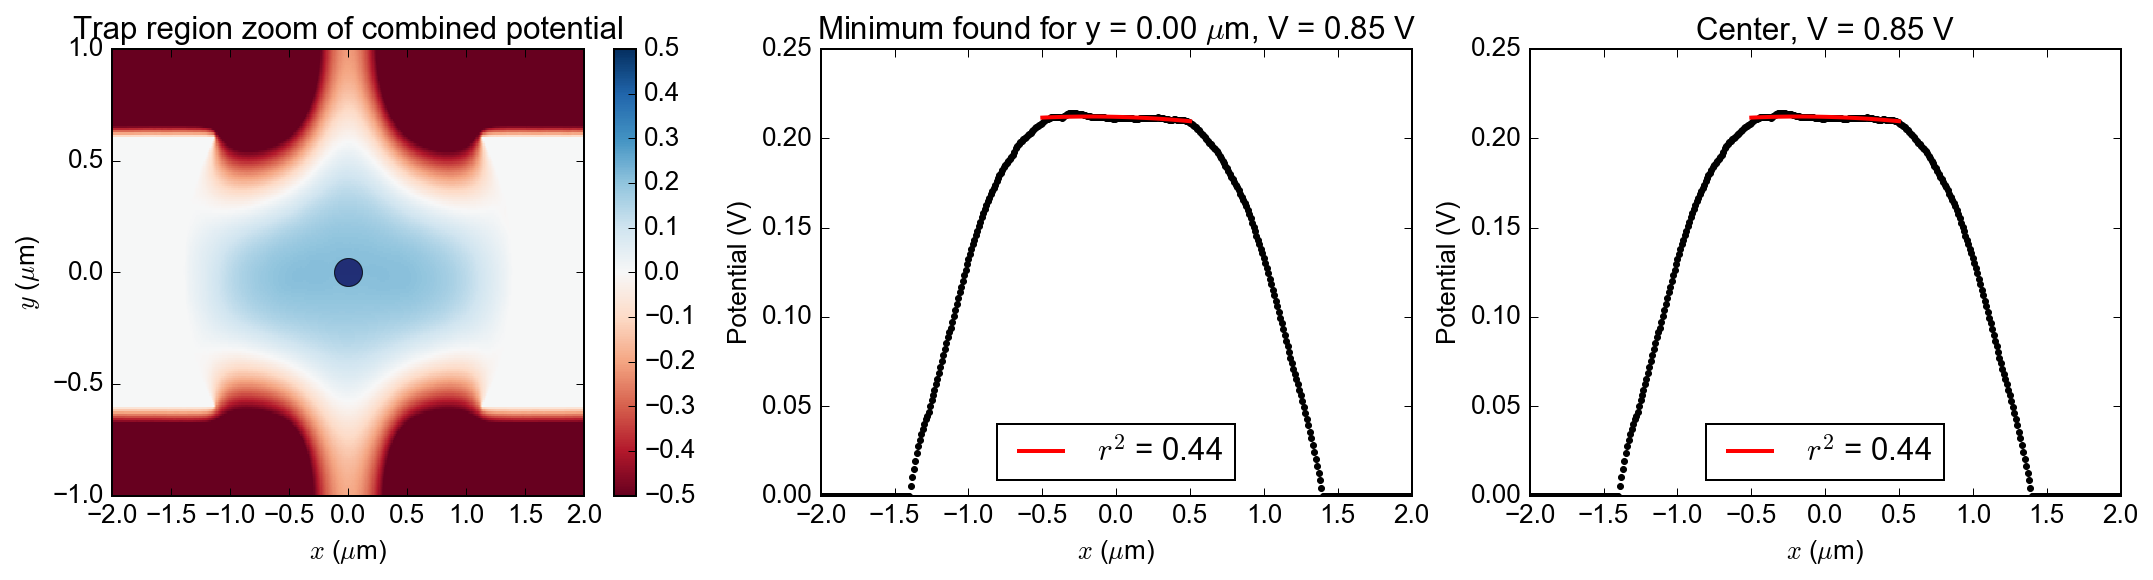

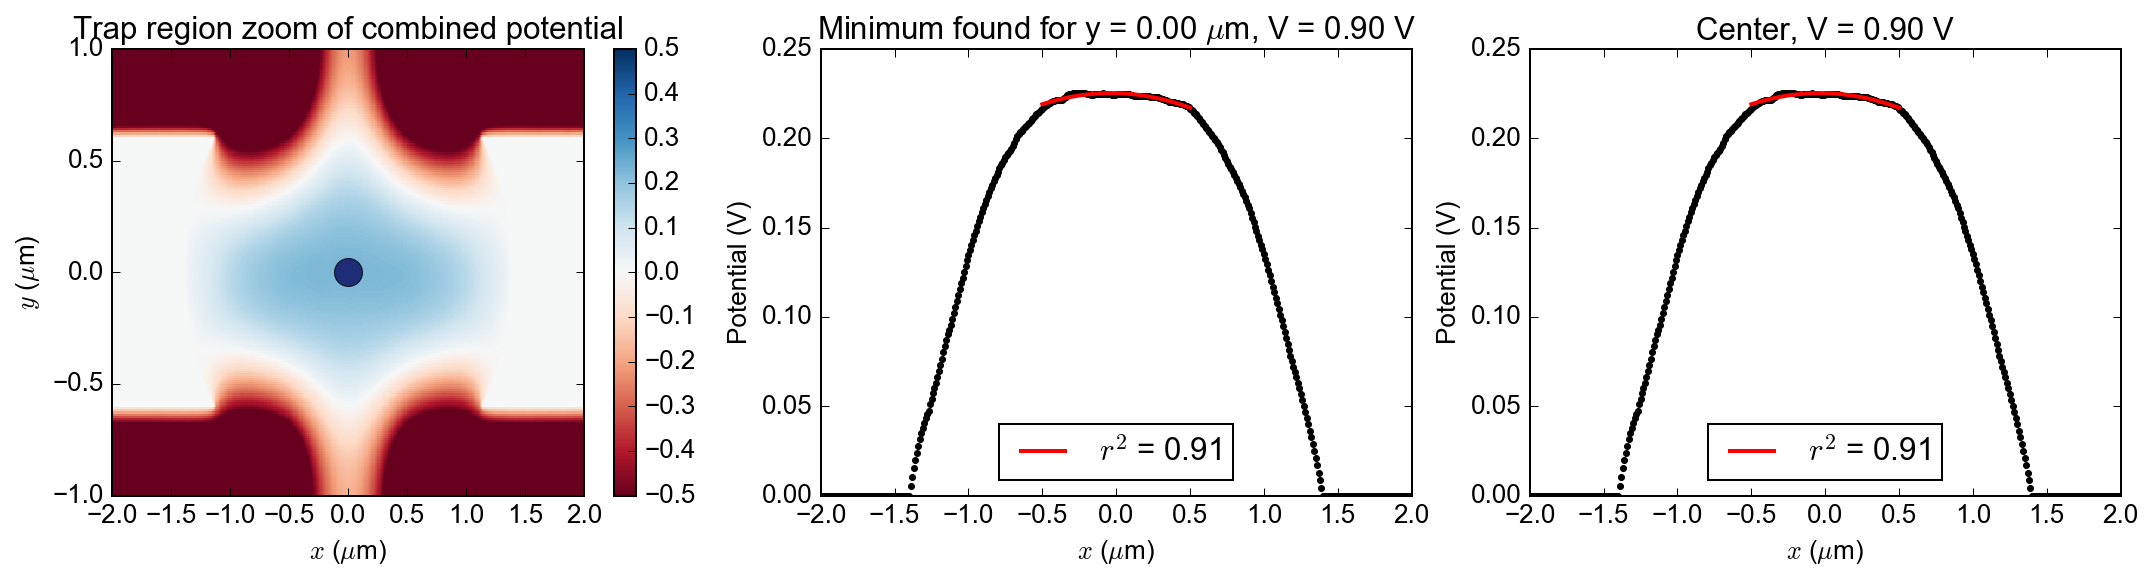

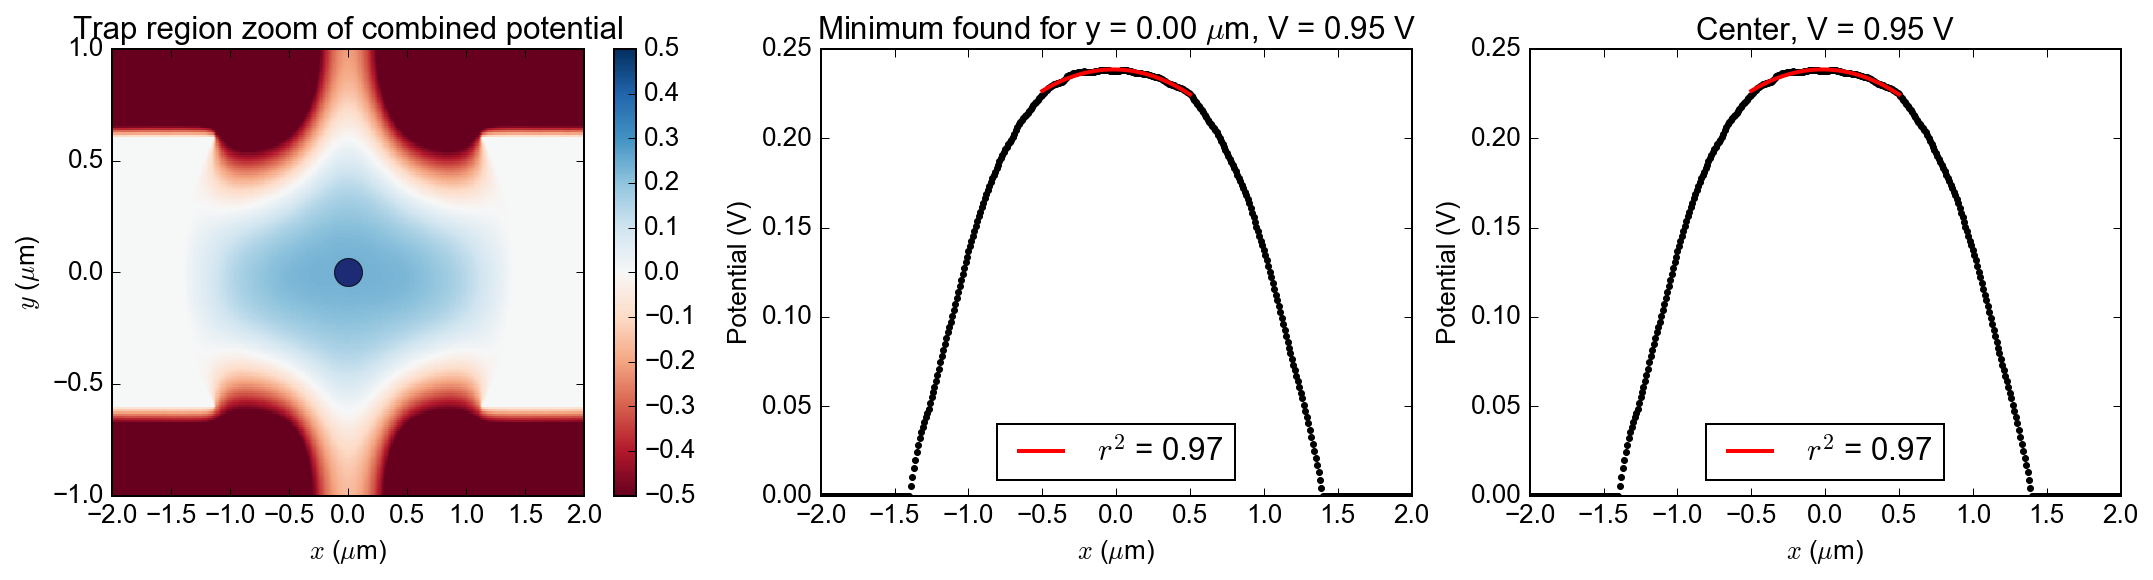

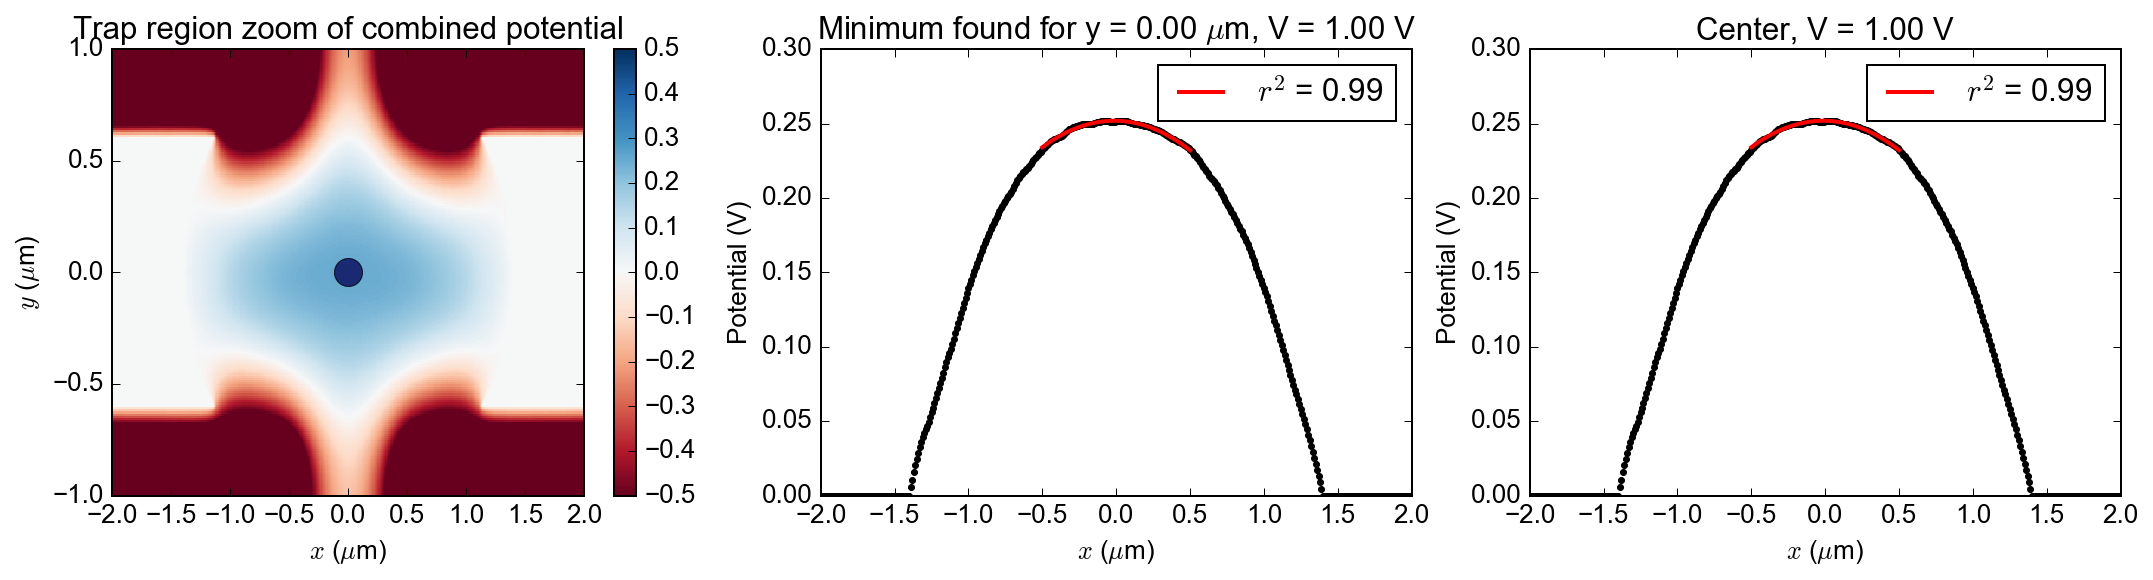

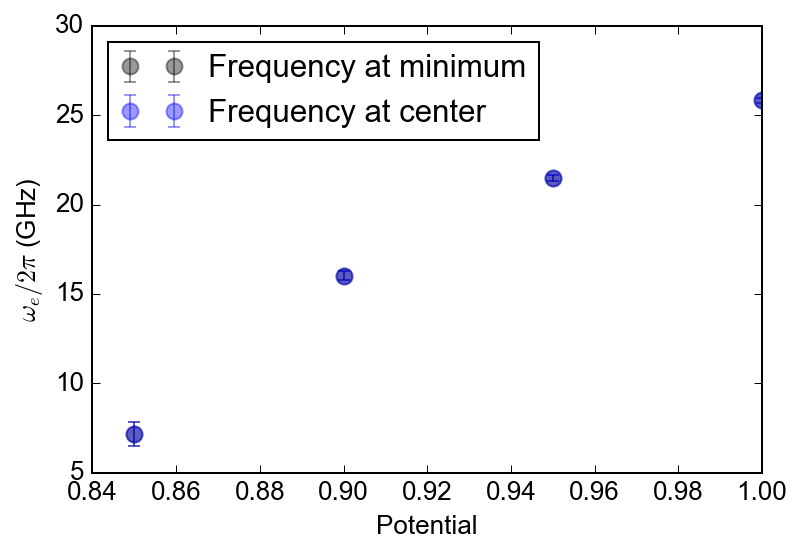

In [36]:
sweep_voltage = linspace(0.50, 1.00, 11)
coefficients = [1.5, 0.50, -2.15, -1.5, 0]
fmin, sigmamin, fctr, sigmactr = trap_analysis.sweep_electrode_voltage(x, y, cropped_potentials, coefficients, 
                                                                       sweep_voltage, sweep_electrode_idx=1, 
                                                                       fitdomain=(-0.5E-6, 0.5E-6), clim=(-0.5,0.5), 
                                                                       do_plot=True, print_report=True)

Let's take some cuts along x and plot the electron frequency:

======  =============  ===============
  y      f_min (GHz)    sigma_f (GHz)
======  =============  ===============
-0.000     24.144           0.099
-0.000     21.103           0.093
-0.000     18.290           0.133
-0.000     15.795           0.208
-0.000     13.685           0.298
-0.000     12.354           0.372
-0.000     10.510           0.417
-0.000      9.401           0.458
-0.000      9.452           0.427
-0.000     10.460           0.395
0.000      12.426           0.370
0.000      14.922           0.331
0.000      17.628           0.258
0.000      20.357           0.180
0.000      22.780           0.128
0.000      25.282           0.103
0.000      28.121           0.085
0.000      31.159           0.072
0.000      34.693           0.081
0.000      38.361           0.079
0.000      41.884           0.080
======  =============  ===============


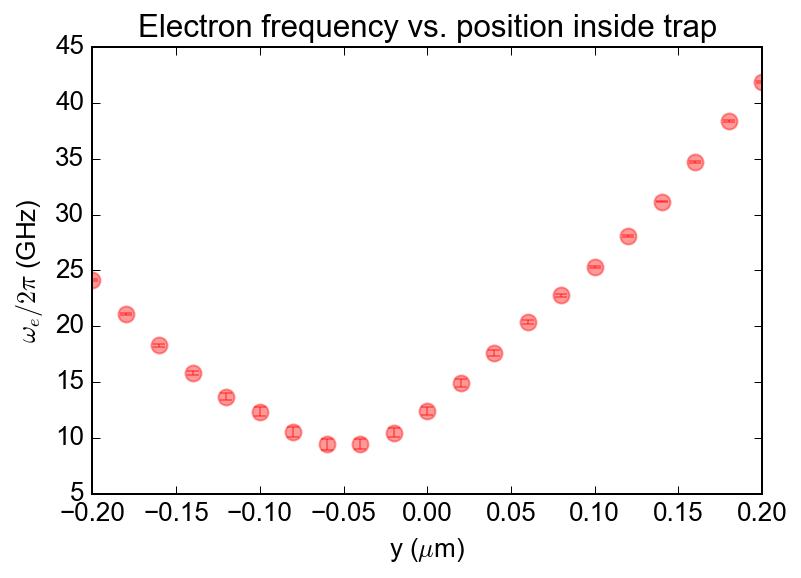

In [43]:
coefficients = [1.5, 0.875, -2.15, -1.5, 0]
sweep_data = linspace(-0.2E-6, 0.2E-6, 21)
trap_analysis.sweep_trap_coordinate(x, y, cropped_potentials, coefficients, sweep_data, sweep_coordinate='y',
                                    fitdomain=(-0.5E-6, 0.5E-6), do_plot=False, print_report=True)

Requirements for the potential landscape
* Electron frequency of around 10 GHz
* Curvature in the $x$-direction should be smaller than in the $y$-direction
* The electron frequency should be measured at the minimum of the potential, not the center of the trap
* The potential depth should be large enough to prevent leakage.

Let's look at the $y$-direction now:

f = 75.667 +/- 0.097 GHz


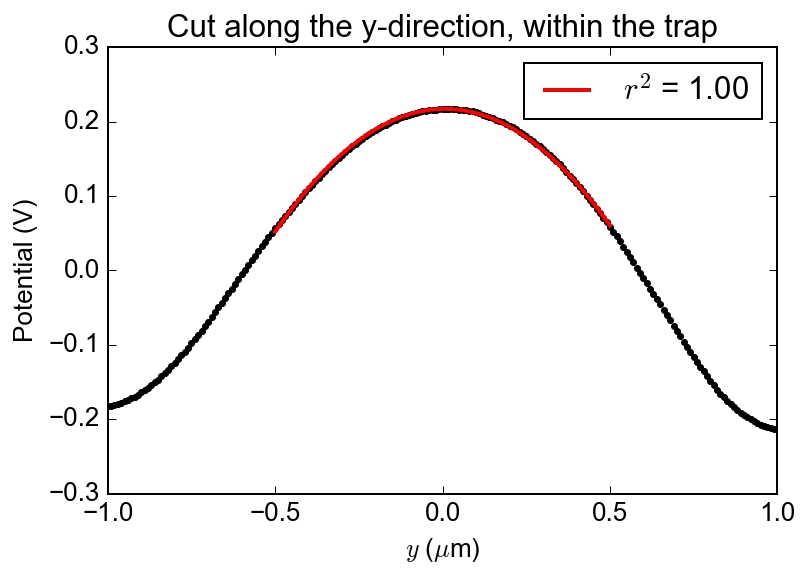

In [21]:
coefficients = [1.5, 0.87, -2.15, -1.5, 0]
V = trap_analysis.get_combined_potential(array(cropped_potentials), array(coefficients))
yminidx = argmax(V)/shape(V)[1]

fig=plt.figure(figsize=(6.,4.))
common.configure_axes(13)

fr, ferr = trap_analysis.fit_electron_potential(np.array(y, dtype=float64)*1E6, 
                                                np.array(V[:, len(x)/2], dtype=float64), 
                                                fitdomain=(-0.5, 0.5), do_plot=True, 
                                                plot_title='Cut along the y-direction, within the trap')
    
f, sigma_f = trap_analysis.get_electron_frequency(fr, ferr, verbose=True)

plt.xlim(np.min(y*1E6), np.max(y*1E6))
plt.xlabel('$y$ ($\mu$m)')
plt.ylabel('Potential (V)')

common.save_figure(fig, save_path=nbfig_dir)

Let's look at a cut in the resonator now

f = 110.089 +/- 0.272 GHz


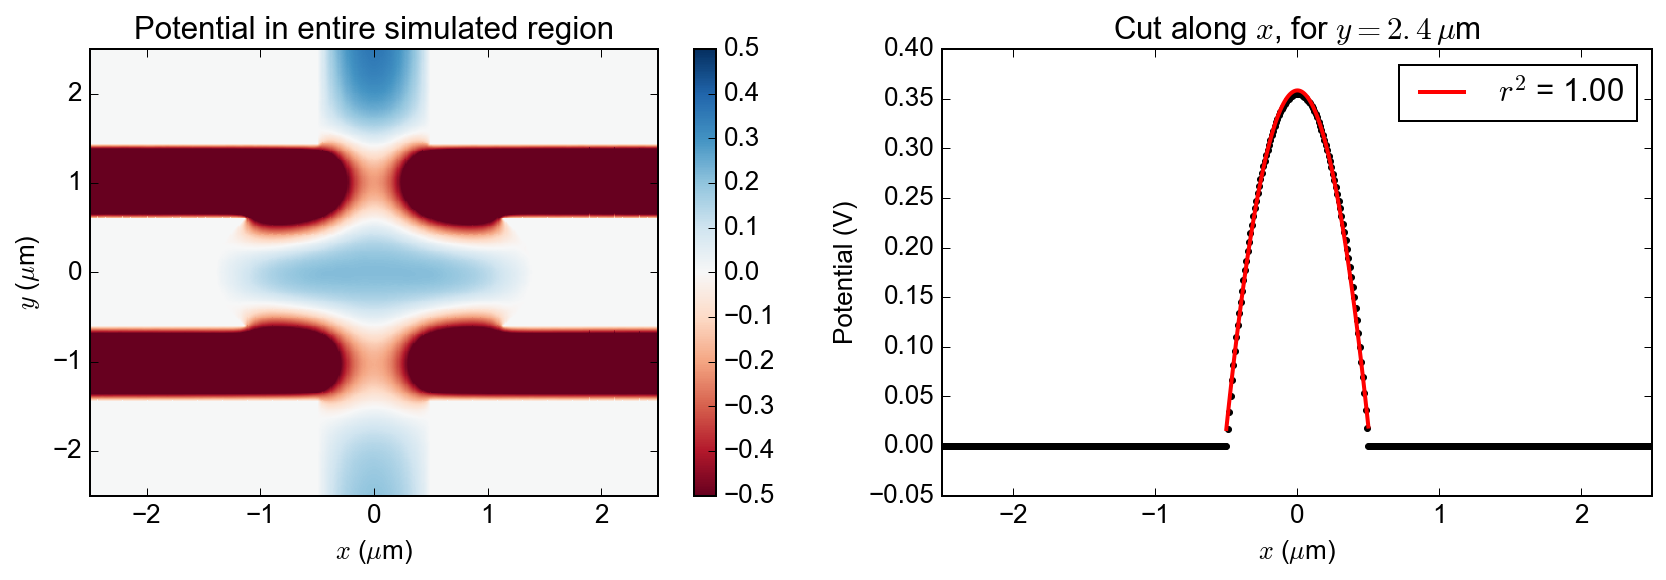

In [22]:
potentials = [resonator['V'], currentloop['V'], rightgate['V'], leftgate['V'], midgate['V']]
coefficients = [1.5, 0.87, -2.15, -1.5, 0]

big_potential = trap_analysis.get_combined_potential(array(potentials), array(coefficients))

fig=plt.figure(figsize=(14.,4.))
plt.subplot(121)
common.configure_axes(13)
plt.title('Potential in entire simulated region')
plt.pcolormesh(resonator['x']*1E6, resonator['y']*1E6, big_potential, cmap=plt.cm.RdBu, vmin=-0.5, vmax=0.5)
plt.xlim(np.min(resonator['x']*1E6), np.max(resonator['x']*1E6))
plt.ylim(np.min(resonator['y']*1E6), np.max(resonator['y']*1E6))
plt.colorbar()
plt.xlabel('$x$ ($\mu$m)')
plt.ylabel('$y$ ($\mu$m)')

plt.subplot(122)
fr, ferr = trap_analysis.fit_electron_potential(np.array(resonator['x'][:,0]*1E6, dtype=float64), 
                                  np.array(big_potential[:, common.find_nearest(resonator['y'], 2.4E-6)], dtype=float64), 
                                  fitdomain=(-0.5, 0.5), do_plot=True, 
                                  plot_title='Cut along $x$, for $y = 2.4 \,\mu$m')
    
f, sigma_f = trap_analysis.get_electron_frequency(fr, ferr, verbose=True)
plt.ylim(-0.05, 0.40)

#common.save_figure(fig, save_path=nbfig_dir)

To be sure nothing funky is going on with the resonator, we have to consider the wider part of the resonator too. We have simulated this before, because we needed to know the level meter response. Let's look at this simulation again.

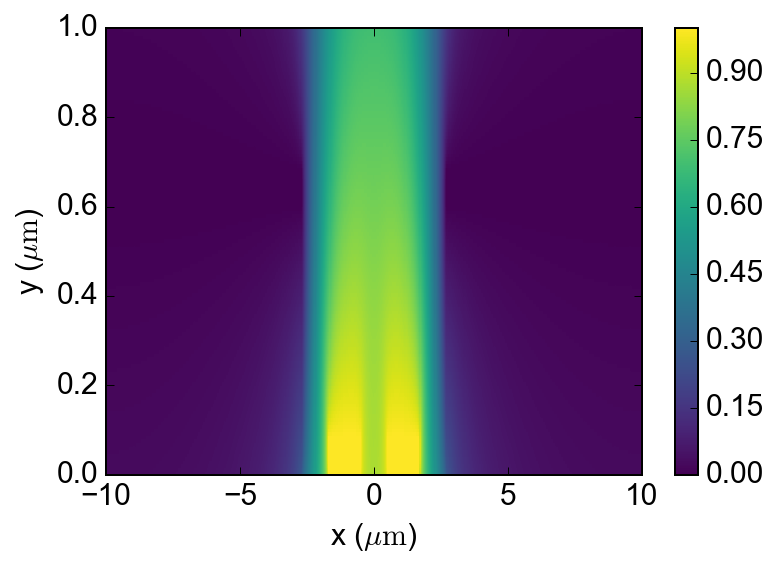

In [60]:
x, y, V = static_surface.load_maxwell_data(os.path.join(base_path, "XZ_resonator_1V.fld"), do_log=False, 
                                           figsize=(6.,4.), plot_axes='xy', cmap=plt.cm.viridis, ylim=(0, 1))

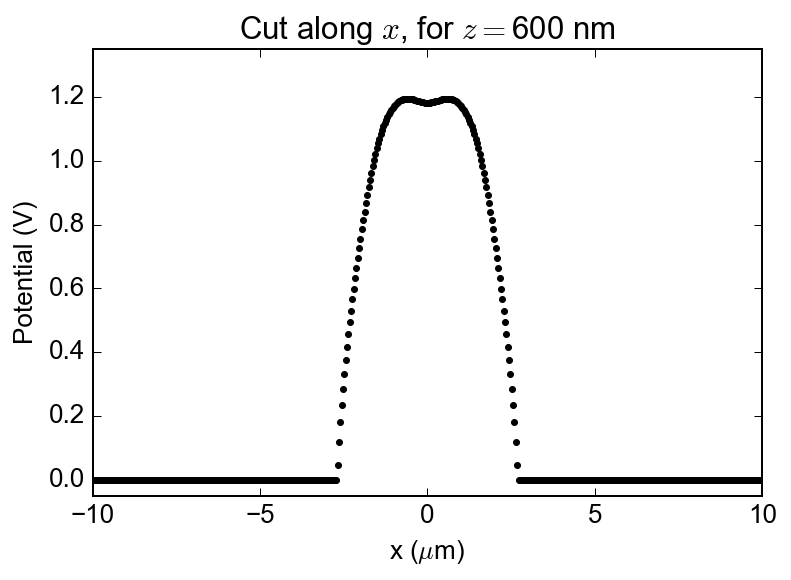

In [66]:
coefficient = 1.5;

fig=plt.figure()
common.configure_axes(13)
plt.plot(x[:,0]*1E6, coefficient*V[:,common.find_nearest(y, 0.6E-6)], '.k')
plt.xlabel('x ($\mu$m)')
plt.ylabel('Potential (V)')
plt.ylim(-0.05, 1.35)
plt.title('Cut along $x$, for $z = $600 nm')

common.save_figure(fig, save_path=nbfig_dir)

What if there were two electrons in the trap? What will the potential barrier need to be to keep the electrons in the trap? 

5.76668573145e-07


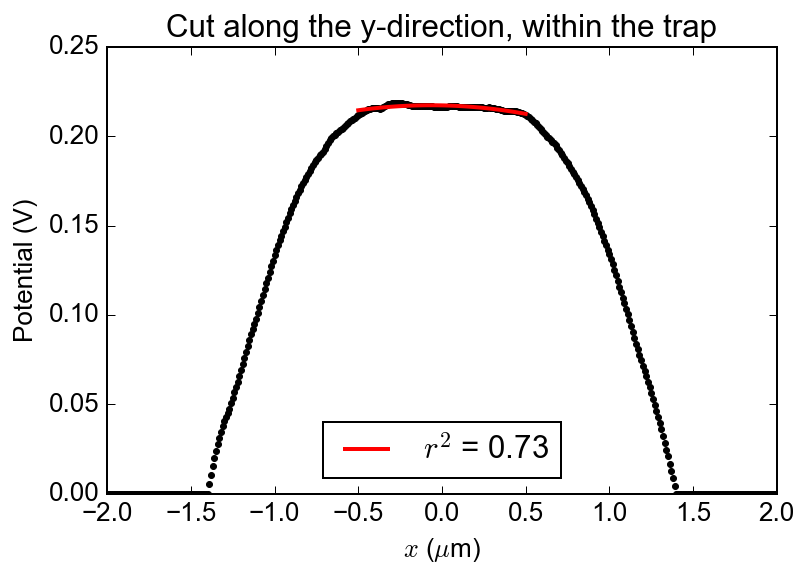

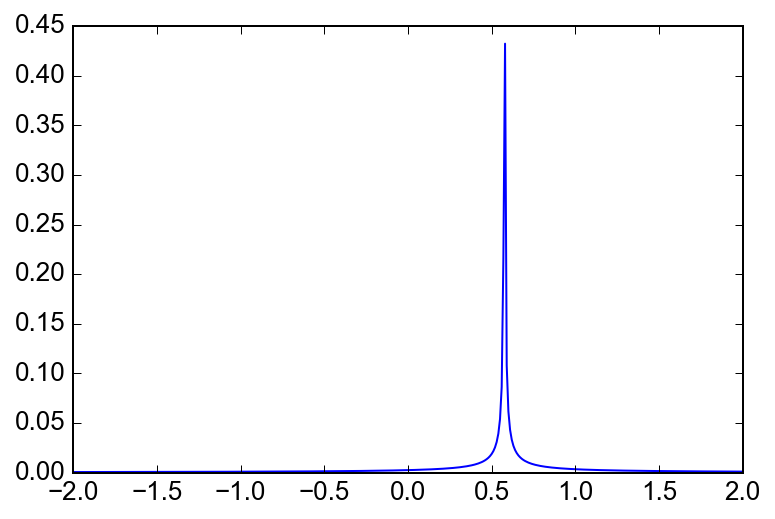

In [108]:
coefficients = [1.5, 0.87, -2.15, -1.5, 0]
V = get_combined_potential(array(cropped_potentials), array(coefficients))
yminidx = argmax(V)/shape(V)[1]

yidx = common.find_nearest(y, Y)
fig=plt.figure(figsize=(6.,4.))
common.configure_axes(13)
fr, ferr = fit_electron_potential(array(x, dtype=float64)*1E6, array(V[yminidx, :], dtype=float64), 
                                        fitdomain=(-0.5, 0.5), do_plot=True, 
                                        plot_title='Cut along the y-direction, within the trap')

f, sigma_f = get_electron_frequency(fr, ferr, verbose=False)

c = get_constants()
ktrap = 2*fr[1]*1E+12*c['e']
d = (-2*c['e']**2/(2*pi*ktrap*c['eps0']))**(1/3.)

print d

Velectron = c['e']/(4*pi*c['eps0']) * 1/abs(d-x)

plt.figure()
plt.plot(array(x, dtype=float64)*1E6, Velectron)